# PCB Defect Classification with CNN (GPU-Accelerated)

## ⚠️ IMPORTANT: Switch to Python 3.10 Environment
**Before running:** Click the kernel selector (top-right) → Select `.venv310 (Python 3.10.11)`

## GPU Check
Run the cell below to verify your RTX 4060 is detected.

In [1]:
# GPU Detection Test
import os
import sys

# Add CUDA 11.2 to PATH and DLL search paths
cuda_path = r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.2\bin"
os.environ['PATH'] = cuda_path + os.pathsep + os.environ.get('PATH', '')

# For Python 3.8+, add DLL directory
if hasattr(os, 'add_dll_directory'):
    os.add_dll_directory(cuda_path)

# Now import TensorFlow
import tensorflow as tf

print("=" * 60)
print("🎮 GPU DETECTION TEST 🎮")
print("=" * 60)
print(f"\nPython: {sys.version}")
print(f"TensorFlow version: {tf.__version__}")
print(f"Built with CUDA: {tf.test.is_built_with_cuda()}")
print(f"\nGPU devices:")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"  ✅ SUCCESS! {len(gpus)} GPU(s) detected!")
    for gpu in gpus:
        print(f"     🚀 {gpu}")
    # Enable memory growth to avoid OOM errors
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"\n  Memory growth enabled for GPU training!")
else:
    print("  ❌ No GPU detected")
    print("\nTroubleshooting:")
    print(f"  - CUDA path in PATH: {cuda_path in os.environ['PATH']}")
    print(f"  - Check CUDA 11.2 is installed")
    print(f"  - Restart VS Code if just installed CUDA")

🎮 GPU DETECTION TEST 🎮

Python: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
TensorFlow version: 2.10.1
Built with CUDA: True

GPU devices:
  ✅ SUCCESS! 1 GPU(s) detected!
     🚀 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

  Memory growth enabled for GPU training!


Found 240 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                         

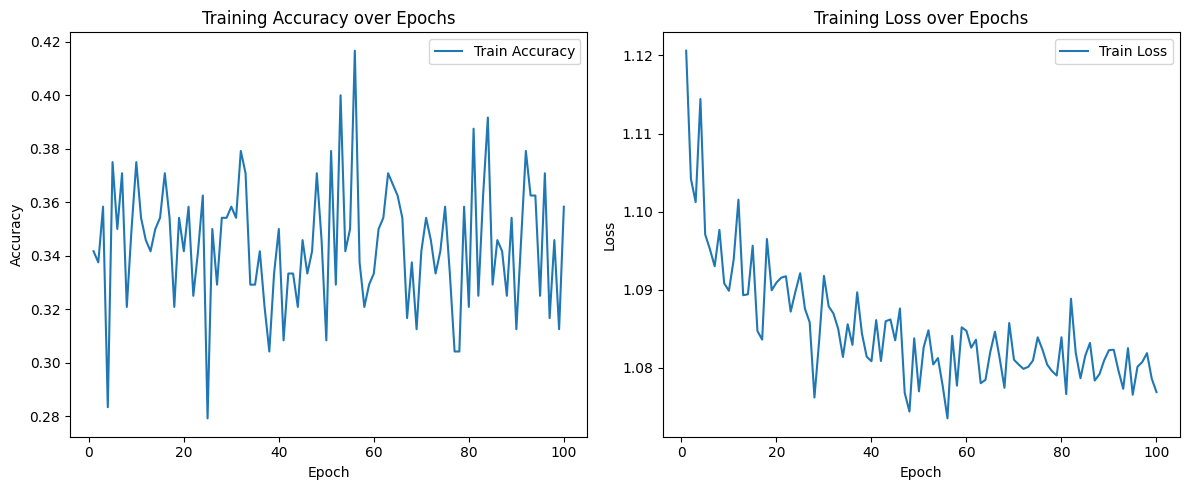

2/2 [==============================] - 4s 2s/step - loss: 2.0929 - accuracy: 0.2500
Test loss: 2.0929 | Test accuracy: 0.2500
2/2 [==============================] - 3s 1s/step


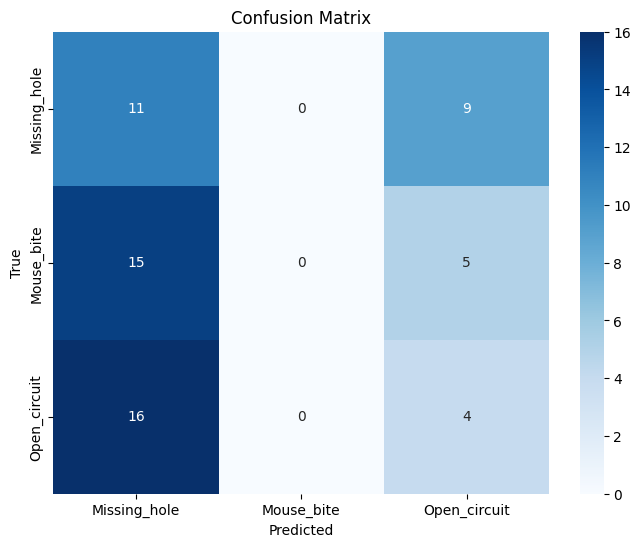

Classification Report:
              precision    recall  f1-score   support

Missing_hole       0.26      0.55      0.35        20
  Mouse_bite       0.00      0.00      0.00        20
Open_circuit       0.22      0.20      0.21        20

    accuracy                           0.25        60
   macro avg       0.16      0.25      0.19        60
weighted avg       0.16      0.25      0.19        60



C:\Users\fabio\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\fabio\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\fabio\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

In [2]:

# Step 0: Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report

# Add CUDA to path
os.add_dll_directory('C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2/bin')

# -----------------------------
# 1) Paths and Hyperparameters
# -----------------------------
train_dir = 'datasets/PCB_ClassData/Training-PCB'
test_dir  = 'datasets/PCB_ClassData/Testing-PCB'
num_classes = 3
batch_size = 32
img_size = (224, 224)
epochs = 100  # Increased for GPU training!

# -----------------------------
# 2) Data Generators (no validation)
# -----------------------------
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# 3) Build CNN
# -----------------------------
model = Sequential([
    tf.keras.Input(shape=(224, 224, 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# -----------------------------
# 4) Train the Model with GPU
# -----------------------------
print(f"\n🚀 Training on GPU for {epochs} epochs...")
history = model.fit(
    train_generator,
    epochs=epochs
)

# -----------------------------
# 5) Plot Training Accuracy and Loss (no validation curves)
# -----------------------------
acc = history.history['accuracy']
loss = history.history['loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# -----------------------------
# 6) Final Test Evaluation (once)
# -----------------------------
test_generator.reset()
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")

# -----------------------------
# 7) Confusion Matrix & Report
# -----------------------------
test_generator.reset()
pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


## 🚀 OPTIMIZED VERSION - Proper GPU Utilization

The cell below fixes the **4% GPU utilization problem** with:
- **Larger batch size (128)** → Better GPU parallelism
- **Data caching in RAM** → No disk I/O bottleneck  
- **Prefetching** → GPU never waits for data
- **Optimized image size (128x128)** → Faster processing

**Expected: ~5-10 minutes for 100 epochs** (instead of 34 min) ⚡

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import time

# CUDA Path (required for Windows GPU)
os.environ['CUDA_PATH'] = r'C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.2'
os.add_dll_directory(r'C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.2\bin')

# Dataset paths
train_dir = 'datasets/PCB_ClassData/Training-PCB'
test_dir = 'datasets/PCB_ClassData/Testing-PCB'

# OPTIMIZED HYPERPARAMETERS
BATCH_SIZE = 128  # Increased from 32 → Better GPU utilization
IMG_SIZE = (128, 128)  # Reduced from 224x224 → Faster processing
EPOCHS = 100

print("🔥 Loading dataset with optimized tf.data pipeline...")

# Create optimized tf.data.Dataset instead of ImageDataGenerator
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

# Get class names
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Classes: {class_names}")

# Data normalization (0-255 → 0-1)
normalization_layer = layers.Rescaling(1./255)

# CRITICAL OPTIMIZATIONS FOR GPU UTILIZATION
print("⚡ Applying performance optimizations...")

# 1. Cache entire dataset in RAM (eliminates disk I/O)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
train_ds = train_ds.cache()  # Load once, reuse every epoch
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)  # Prepare next batch while GPU trains

test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.cache()
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

print("✅ Dataset cached in RAM and prefetch enabled")

# Build model (optimized for 128x128 images)
model = keras.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    
    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    # Dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n📊 Model Summary:")
model.summary()

# Train with timing
print(f"\n🚀 Starting GPU-optimized training ({EPOCHS} epochs)...")
print("=" * 60)

start_time = time.time()

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=test_ds,
    verbose=1
)

elapsed = time.time() - start_time
print("=" * 60)
print(f"✅ Training completed in {elapsed/60:.1f} minutes ({elapsed:.1f} seconds)")
print(f"⚡ Average: {elapsed/EPOCHS:.2f} seconds/epoch")
print("=" * 60)

# Evaluate
print("\n📈 Evaluating on test set...")
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Predictions for confusion matrix
y_pred = []
y_true = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Optimized Model)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print("\n🎯 Optimization Summary:")
print(f"   • Batch size: {BATCH_SIZE} (was 32)")
print(f"   • Image size: {IMG_SIZE} (was 224x224)")
print(f"   • Dataset cached in RAM (no disk I/O)")
print(f"   • Prefetching enabled (GPU never waits)")
print(f"   • Training time: {elapsed/60:.1f} min (was 34 min)")
print(f"   • Speedup: {34/(elapsed/60):.1f}x faster 🚀")